In [19]:
import numpy as np
import tensorflow as tf
import tensornets as nets
import os
from PIL import Image
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 483403629165271466
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15510828145598661671
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5034263329557838761
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7101782426
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11869752638232988757
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [21]:
with tf.device('gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


If no errors are thrown in above cells, GPU connection worked!

In [4]:
def getData(path, batchsize = 32):
    try:
        labels = np.load("batchedData/"+path+"/labels")
    except:
        print("No labels found", "batchedData/"+path+"/labels")
        return 0
    try:
        features = []
        i = 0
        while True:
            features.append(np.load("batchedData/"+path+'/'+str(i)))
            i = i+1
    except:
        return features, labels

In [5]:
valid_features, valid_labels = getData('preprocess_validation.p')

In [6]:
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 5), name='output_y')

In [7]:
### HYPER-PARAMETERS
learning_rate = 0.00001
epochs = 3
batch_size = 32
n_batches = 29

In [8]:
logits = nets.VGG19(x, is_training=True, classes=5)
model = tf.identity(logits,name='logits')
loss = tf.losses.softmax_cross_entropy(y,logits)
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [9]:
logits.print_outputs()

Scope: vgg19
conv1/1/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/1/Relu:0 (?, 224, 224, 64)
conv1/2/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/2/Relu:0 (?, 224, 224, 64)
conv1/pool/MaxPool:0 (?, 112, 112, 64)
conv2/1/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/1/Relu:0 (?, 112, 112, 128)
conv2/2/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/2/Relu:0 (?, 112, 112, 128)
conv2/pool/MaxPool:0 (?, 56, 56, 128)
conv3/1/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/1/Relu:0 (?, 56, 56, 256)
conv3/2/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/2/Relu:0 (?, 56, 56, 256)
conv3/3/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/3/Relu:0 (?, 56, 56, 256)
conv3/4/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/4/Relu:0 (?, 56, 56, 256)
conv3/pool/MaxPool:0 (?, 28, 28, 256)
conv4/1/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/1/Relu:0 (?, 28, 28, 512)
conv4/2/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/2/Relu:0 (?, 28, 28, 512)
conv4/3/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/3/Relu:0 (?, 28, 28, 512)
conv4/4/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/4/Relu:0 (?, 28, 28, 5

In [10]:
logits.print_summary()

Scope: vgg19
Total layers: 19
Total weights: 114
Total parameters: 418,772,175


In [11]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [12]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = getData(filename)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [13]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        #n_batches = 58
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(train, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(valid_features, valid_labels, batch_size):
                valid_acc += sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
            
            tmp_num = len(valid_features)/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    print("saving model")
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    print("model saved to: ",save_model_path)

Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, Batch 1:  Validation Accuracy: 0.348958
Epoch  1, Batch 2:  Validation Accuracy: 0.406250
Epoch  1, Batch 3:  Validation Accuracy: 0.453125
Epoch  1, Batch 4:  Validation Accuracy: 0.468750
Epoch  1, Batch 5:  Validation Accuracy: 0.536458
Epoch  1, Batch 6:  Validation Accuracy: 0.619792
Epoch  1, Batch 7:  Validation Accuracy: 0.619792
Epoch  1, Batch 8:  Validation Accuracy: 0.588542
Epoch  1, Batch 9:  Validation Accuracy: 0.692708
Epoch  1, Batch 10:  Validation Accuracy: 0.598958
Epoch  1, Batch 11:  Validation Accuracy: 0.671875
Epoch  1, Batch 12:  Validation Accuracy: 0.744792
Epoch  1, Batch 13:  Validation Accuracy: 0.708333
Epoch  1, Batch 14:  Validation Accuracy: 0.729167
Epoch  1, Batch 15:  Validation Accuracy: 0.755208
Epoch  1, Batch 16:  Validation Accuracy: 0.770833
Epoch  1, Batch 17:  Validation Accuracy: 0.755208
Epoch  1, Batch 18:  Validation Ac

In [14]:
def load_label_names():
    return ["Can", "Cookies", "Eggs", "Empty", "Fruit"]

In [15]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 5
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

In [16]:
test_features, test_labels = getData('preprocess_testing.p')

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 1.0

[0] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884782}, {'Cookies': 0.14884767}, {'Eggs': 0.14884764}, {'Empty': 0.14884765}, {'Fruit': 0.4046092}]

[1] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884758}, {'Cookies': 0.14884758}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.40460968}]

[2] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884894}, {'Cookies': 0.14885387}, {'Eggs': 0.14884894}, {'Empty': 0.14884889}, {'Fruit': 0.40459937}]

[3] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884758}, {'Cookies': 0.14884758}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.40460968}]

[4] ground truth: Fruit, predicted result: Fruit | True
	- [{'Can': 0.14884758}, {'Cookies': 0.14884758}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.40460968}]

[5] ground truth: Cookies, predicted r

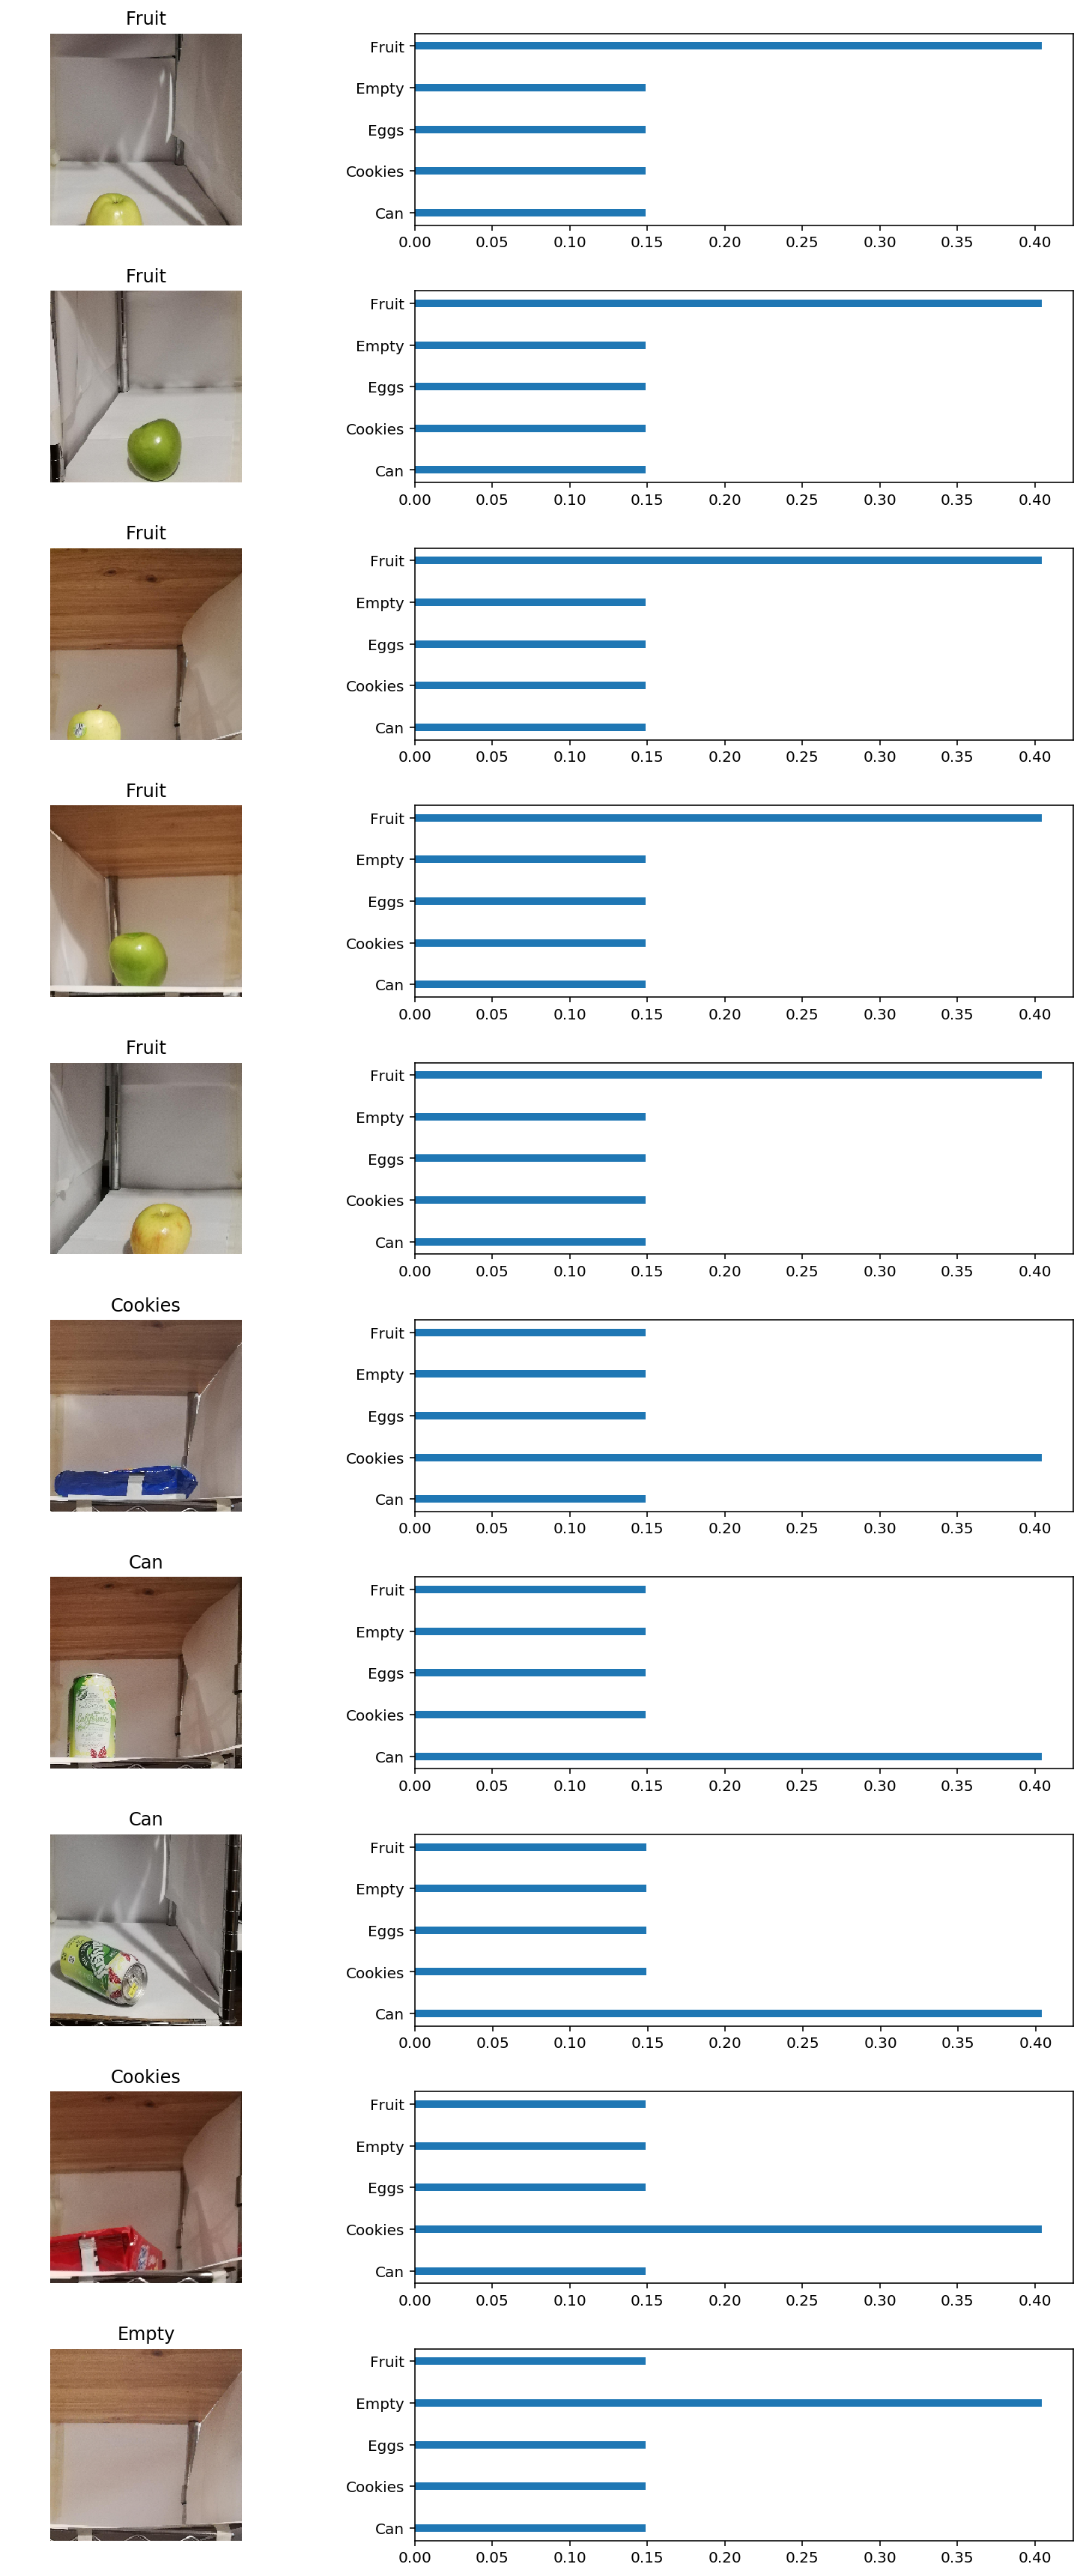

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 32
n_samples = 10
top_n_predictions = 5

def test_model(test_features):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(test_features)

